In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import pack_dynamics
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import copy
kgs.set_float32(True)

local


In [2]:
def canonicize(sol):
    sol.xyt[:,:,0] -= sol.xyt[:,0:1,0]
    sol.xyt[:,:,1] -= sol.xyt[:,0:1,1]

    # mirror solution across X/Y so tree 0 heading lies in [0, pi/2]
    theta0 = cp.remainder(sol.xyt[:,0,2] + np.pi, 2*np.pi) - np.pi

    mirror_x_mask = theta0 < 0
    if cp.any(mirror_x_mask):
        sol.xyt[mirror_x_mask,:,1] *= -1
        sol.xyt[mirror_x_mask,:,2] = -sol.xyt[mirror_x_mask,:,2]
        sol.xyt[mirror_x_mask,:,2] = cp.remainder(sol.xyt[mirror_x_mask,:,2] + np.pi, 2*np.pi) - np.pi
        theta0 = cp.remainder(sol.xyt[:,0,2] + np.pi, 2*np.pi) - np.pi

    mirror_y_mask = theta0 > (np.pi / 2)
    if cp.any(mirror_y_mask):
        sol.xyt[mirror_y_mask,:,0] *= -1
        sol.xyt[mirror_y_mask,:,2] = np.pi - sol.xyt[mirror_y_mask,:,2]
        sol.xyt[mirror_y_mask,:,2] = cp.remainder(sol.xyt[mirror_y_mask,:,2] + np.pi, 2*np.pi) - np.pi

    # shift tree 2 by the crystal axes such that it is just to the top right of tree 0
    crystal_axes = sol.get_crystal_axes_allocate()
    vec_a = crystal_axes[:,0,:2]
    vec_b = crystal_axes[:,1,:2]
    det = vec_a[:,0]*vec_b[:,1] - vec_a[:,1]*vec_b[:,0]
    if cp.any(cp.abs(det) <= 1e-9):
        raise ValueError("Degenerate crystal axes detected")
    pos_tree1 = sol.xyt[:,1,:2]
    coeff_a = (vec_b[:,1]*pos_tree1[:,0] - vec_b[:,0]*pos_tree1[:,1]) / det
    coeff_b = (-vec_a[:,1]*pos_tree1[:,0] + vec_a[:,0]*pos_tree1[:,1]) / det
    coeff_a = cp.mod(coeff_a, 1.0)
    coeff_b = cp.mod(coeff_b, 1.0)
    pos_aligned = coeff_a[:,None]*vec_a + coeff_b[:,None]*vec_b
    sol.xyt[:,1,:2] = pos_aligned

def find_optimal_tesselation(aspect_ratio, angle_degrees, N=20000, max_N =80000, check_val=10, show_plots=False):
    sol = kgs.SolutionCollectionLatticeFixed()
    sol.periodic = True
    sol.aspect_ratios = cp.array([aspect_ratio]*N, dtype=kgs.dtype_cp)
    sol.angles = cp.array([np.radians(angle_degrees)]*N, dtype=kgs.dtype_cp)
    sol = sol.create_empty(N, 2)
    sol.xyt[:,0,:2] = 0.
    generator = cp.random.default_rng(seed=42)
    sol.xyt[:,:,2] = generator.uniform(0, 2*np.pi, size=(N,2), dtype=kgs.dtype_cp)
    sol.xyt[:,1,2] = sol.xyt[:,0,2] + np.pi
    sol.xyt[:,1,:2] = generator.uniform(0, 2, size=(N,2), dtype=kgs.dtype_cp)

    sol.h[:,0] = 1.
    sol.snap()

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.n_iterations *= 1
    sol = optimizer.run_simulation(sol)

    canonicize(sol)
    

    cost_vals = optimizer.cost.compute_cost_allocate(sol)[0].get()
    #plt.figure()
    #plt.semilogy(np.sort(cost_vals))

    inds = np.argsort(cost_vals)

    if not cost_vals[inds[check_val]]<=1.001*cost_vals[inds[0]] and 2*N<=max_N:
        #print('trying higher N')
        s = find_optimal_tesselation(aspect_ratio, angle_degrees, N=2*N)
        #print('ok now')
        return s
    
    
    sol.select_ids(inds[:1])

    sol2 = kgs.SolutionCollectionLattice()
    sol2.periodic = True
    sol2.xyt = copy.deepcopy(sol.xyt)
    sol2.h = cp.zeros((sol.N_solutions, 3), dtype=kgs.dtype_cp)
    sol2.h[:,0] = sol.h[:,0]
    sol2.h[:,1] = sol.h[:,0] * sol.aspect_ratios        
    sol2.h[:,2] = sol._get_angles()

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-2
    #optimizer.dt*=10
    optimizer.n_iterations *= 3
    optimizer.track_cost = show_plots
    optimizer.plot_cost = show_plots
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    sol2 = optimizer.run_simulation(sol2)

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-3
    #optimizer.dt*=10
    optimizer.n_iterations *= 3
    optimizer.track_cost = show_plots
    optimizer.plot_cost = show_plots
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    sol2 = optimizer.run_simulation(sol2)
    canonicize(sol2)
    return sol, sol2


In [3]:
from tqdm import tqdm
aspect_ratios = np.linspace(0.35,0.65,31)
angles = np.linspace(30,90,61)
res1 = np.zeros((len(aspect_ratios), len(angles)))
res2 = np.zeros((len(aspect_ratios), len(angles)))
sol_grid = [[None for _ in range(len(angles))] for _ in range(len(aspect_ratios))]
sol_opt_grid = [[None for _ in range(len(angles))] for _ in range(len(aspect_ratios))]
for ia, aspect_ratio in enumerate(tqdm(aspect_ratios)):
    for ib, angle in enumerate(angles):
        sol, sol_opt = find_optimal_tesselation(aspect_ratio, angle)
        res1[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(sol)[0][0].get()
        res2[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(sol_opt)[0][0].get()
        sol_grid[ia][ib] = sol
        sol_opt_grid[ia][ib] = sol_opt





  0%|          | 0/31 [00:00<?, ?it/s]

init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 21.119 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : F

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
  3%|▎         | 1/31 [09:49<4:54:57, 589.93s/it]


KeyboardInterrupt: 

In [ ]:
kgs.dill_save(kgs.temp_dir + '/packings2.pickle', (sol_grid, sol_opt_grid))

In [ ]:
# make a function to plot heatmaps of res1 or res2, with proper axis labels
def plot_heatmaps(res, aspect_ratios, angles, title="Cost Heatmap", cbar_label="Area Cost", clim=None):
    aspect_ratios = np.asarray(aspect_ratios)
    angles = np.asarray(angles)
    if res.shape != (len(aspect_ratios), len(angles)):
        raise ValueError("res must have shape (len(aspect_ratios), len(angles))")

    fig, ax = plt.subplots(figsize=(6, 4))
    extent = [angles.min(), angles.max(), aspect_ratios.min(), aspect_ratios.max()]
    im = ax.imshow(res, origin='lower', extent=extent, aspect='auto', cmap='viridis', interpolation='none')

    if clim is not None:
        im.set_clim(*clim)

    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Aspect ratio (b/a)")
    ax.set_title(title)

    # Use at most ~8 tick labels to avoid clutter
    max_ticks = 8
    x_ticks = np.linspace(angles.min(), angles.max(), min(len(angles), max_ticks))
    y_ticks = np.linspace(aspect_ratios.min(), aspect_ratios.max(), min(len(aspect_ratios), max_ticks))
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.show()
    return fig, ax

In [ ]:
def plot_cost_curves(res1, res2, aspect_ratios, angles, fixed_angle=90.0, title="Cost vs Aspect ratio"):
    aspect_ratios = np.asarray(aspect_ratios)
    angles = np.asarray(angles)
    expected_shape = (len(aspect_ratios), len(angles))
    if res1.shape != expected_shape or res2.shape != expected_shape:
        raise ValueError("res1/res2 must have shape (len(aspect_ratios), len(angles))")

    angle_idx = int(np.argmin(np.abs(angles - fixed_angle)))
    chosen_angle = angles[angle_idx]
    if not np.isclose(chosen_angle, fixed_angle):
        print(f"Using closest available angle: {chosen_angle:.3f} deg")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(aspect_ratios, res1[:, angle_idx], label="Initial lattice", marker="o")
    ax.plot(aspect_ratios, res2[:, angle_idx], label="Optimized lattice", marker="s")
    ax.set_xlabel("Aspect ratio (b/a)")
    ax.set_ylabel("Area cost")
    ax.set_title(f"{title} (angle={chosen_angle:.1f} deg)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
    return fig, ax

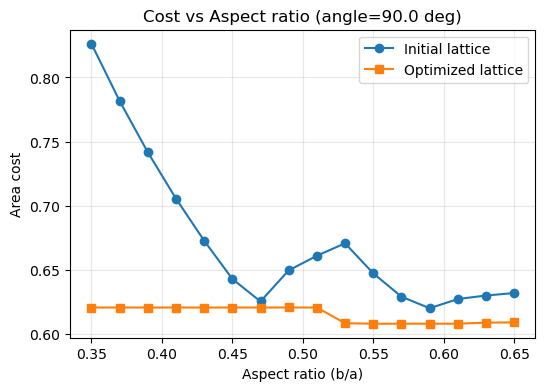

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Cost vs Aspect ratio (angle=90.0 deg)'}, xlabel='Aspect ratio (b/a)', ylabel='Area cost'>)

In [ ]:
plot_cost_curves(res1, res2, aspect_ratios, angles, fixed_angle=90.0)

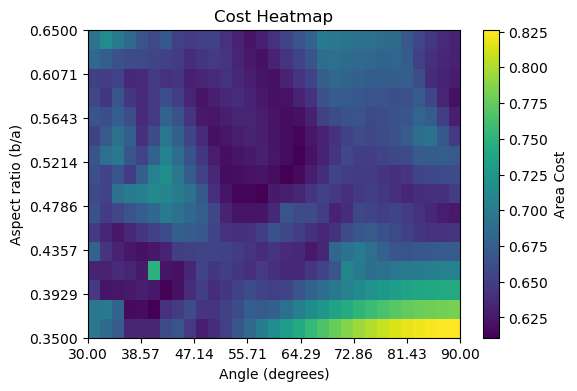

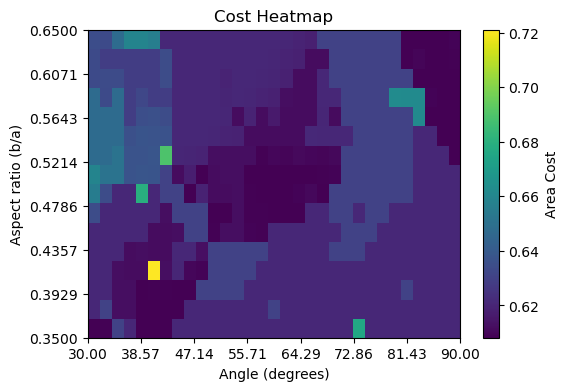

(<Figure size 600x400 with 2 Axes>,
 <Axes: title={'center': 'Cost Heatmap'}, xlabel='Angle (degrees)', ylabel='Aspect ratio (b/a)'>)

In [ ]:
plot_heatmaps(res1, aspect_ratios, angles)
plot_heatmaps(res2, aspect_ratios, angles)


30.0 0.35
0.6834624 0.6122519
0.0014520957 2.302246e-07


(np.float32(36.73275), array(0.36106926, dtype=float32))

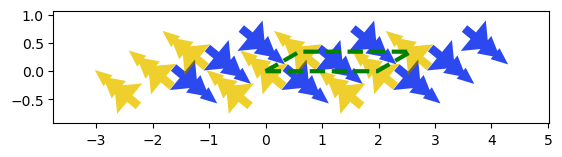

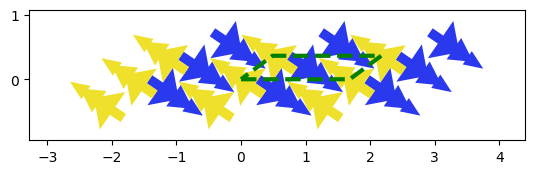

In [ ]:
importlib.reload(pack_dynamics)
aspect_ratio = aspect_ratios[0]
angle = angles[0]
print(angle, aspect_ratio)
sol, sol_opt = find_optimal_tesselation(aspect_ratio, angle, check_val=0, show_plots=False)
print(pack_cost.AreaCost().compute_cost_allocate(sol)[0][0].get(),pack_cost.AreaCost().compute_cost_allocate(sol_opt)[0][0].get())
print(pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0][0].get(),pack_cost.CollisionCostSeparation().compute_cost_allocate(sol_opt)[0][0].get())
pack_vis_sol.pack_vis_sol(sol)
pack_vis_sol.pack_vis_sol(sol_opt)
np.degrees(sol_opt.h[0,2].get()), sol_opt.h[0,1]/sol_opt.h[0,0]

In [ ]:
angles

array([30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54.,
       56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76., 78., 80.,
       82., 84., 86., 88., 90.])

0.60839987 0.60839874


(np.float32(58.41206), array(0.48578185, dtype=float32))

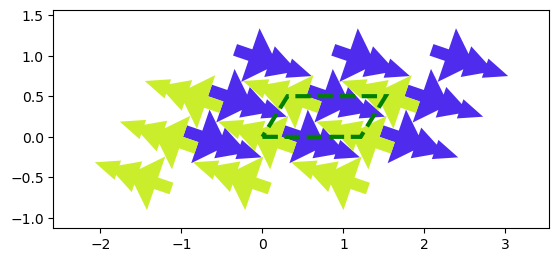

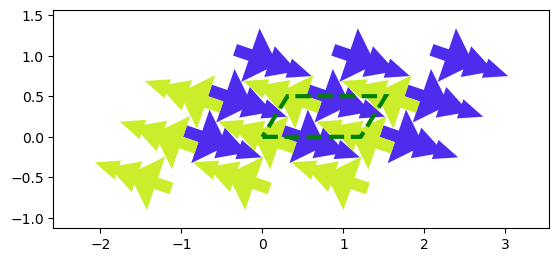

In [ ]:
sol, sol_opt = find_optimal_tesselation(0.4857929, 58.409622, check_val=0)
print(pack_cost.AreaCost().compute_cost_allocate(sol)[0][0].get(),pack_cost.AreaCost().compute_cost_allocate(sol_opt)[0][0].get())
pack_vis_sol.pack_vis_sol(sol)
pack_vis_sol.pack_vis_sol(sol_opt)
np.degrees(sol_opt.h[0,2].get()), sol_opt.h[0,1]/sol_opt.h[0,0]